In [1]:
import torch
from torch import nn

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
!pip install transformers

In [3]:
from transformers import BertTokenizerFast
from transformers import BertForTokenClassification

In [4]:
df = pd.read_csv("/kaggle/input/ner-data/ner.csv")

In [5]:
df.head()

,text,labels
0,Thousands of demonstrators have marched throug...,O O O O O O B-geo O O O O O B-geo O O O O O B-...
1,Iranian officials say they expect to get acces...,B-gpe O O O O O O O O O O O O O O B-tim O O O ...
2,Helicopter gunships Saturday pounded militant ...,O O B-tim O O O O O B-geo O O O O O B-org O O ...
3,They left after a tense hour-long standoff wit...,O O O O O O O O O O O
4,U.N. relief coordinator Jan Egeland said Sunda...,B-geo O O B-per I-per O B-tim O B-geo O B-gpe ...


In [6]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-cased')

In [7]:
maxlen = 0

labels = []
for i in df['labels'].values.tolist():
    if isinstance(i, str):
        labels.append(i.split())
    else:
        labels.append([])

unique_labels = set()
for lb in labels:
  maxlen = max(maxlen, len(lb))
  [unique_labels.add(i) for i in lb if i not in unique_labels]


sentences = df['text'].apply(tokenizer).values
for sts in sentences:
  maxlen = max(maxlen, len(sts['input_ids']))

In [8]:
print(unique_labels)
print(maxlen)

{'I-eve', 'I-nat', 'B-gpe', 'B-art', 'B-eve', 'B-org', 'I-geo', 'I-tim', 'B-geo', 'I-art', 'I-per', 'B-nat', 'I-org', 'B-tim', 'O', 'I-gpe', 'B-per'}
156


In [9]:
df_hold, df_train, df_val, df_test = np.split(df.sample(frac=1,random_state=42), [int(0 * len(df)), int(.96 * len(df)), int(.98 * len(df))])

In [10]:
print(len(df_hold), len(df_train), len(df_val), len(df_test))

0 46040 959 960


In [11]:
def my_tokenizer(sentence):
  tokens = tokenizer.tokenize(sentence)
  tokens = ['[CLS]'] + tokens + ['[SEP]']

  padded_tokens = tokens + ['[PAD]' for _ in range(maxlen - len(tokens))]

  inp = torch.tensor(tokenizer.convert_tokens_to_ids(padded_tokens), dtype = torch.int32)

  attn = torch.tensor([1 if token != '[PAD]' else 0 for token in padded_tokens], dtype = torch.int32)
  seg = torch.tensor([0 for _ in range(len(padded_tokens))], dtype = torch.int32)

  return inp, attn, seg

In [12]:
def tokenize_column(column):
    """Preprocesses a Pandas column and returns input ids, attention masks, and token type ids as 2D arrays."""
    input_ids = torch.empty(0, maxlen)
    attention_masks = torch.empty(0, maxlen)
    token_type_ids = torch.empty(0, maxlen)
    
    for text in column:
        inp, attn, seg = my_tokenizer(text)
        input_ids = torch.cat((input_ids, inp.unsqueeze(0)), dim=0)
        attention_masks = torch.cat((attention_masks, attn.unsqueeze(0)), dim=0)
        token_type_ids = torch.cat((token_type_ids, seg.unsqueeze(0)), dim=0)

    input_ids = input_ids.long()
    attention_masks = attention_masks.long()
    token_type_ids = token_type_ids.long()
    return input_ids, attention_masks, token_type_ids

In [13]:
arr = np.arange(1,18) # 1-17 because we will have a 0 class for empty slots, i.e no word there
dict = {}
for A, B in zip(unique_labels, arr):
    dict[A] = B
dict

{'I-eve': 1,
 'I-nat': 2,
 'B-gpe': 3,
 'B-art': 4,
 'B-eve': 5,
 'B-org': 6,
 'I-geo': 7,
 'I-tim': 8,
 'B-geo': 9,
 'I-art': 10,
 'I-per': 11,
 'B-nat': 12,
 'I-org': 13,
 'B-tim': 14,
 'O': 15,
 'I-gpe': 16,
 'B-per': 17}

In [14]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

def cat_labelize(column):
  labels = [i.split() for i in column.values.tolist()]
  Y_labels = []
  for i in range(len(labels)):
    arr = []
    for j in range(len(labels[i])):
      arr.append(int(dict[labels[i][j]]))
    arr = np.array(arr, dtype = 'int32').astype('int32')
    Y_labels.append(arr)
  Y_labels = np.array(Y_labels)
  Y_cat = pad_sequences(Y_labels, maxlen = maxlen,  padding = 'post', truncating = 'post')
  Y_cat = to_categorical(Y_cat, num_classes=18)
  return Y_cat

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [15]:
inp_train, attn_train, seg_train = tokenize_column(df_train['text'])
inp_val, attn_val, seg_val = tokenize_column(df_val['text'])
inp_test, attn_test, seg_test = tokenize_column(df_test['text'])

In [16]:
ycat_train = cat_labelize(df_train['labels'])
ycat_val = cat_labelize(df_val['labels'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  del sys.path[0]


In [17]:
def labelize_test(column):
  labels = [i.split() for i in column.values.tolist()]
  Y_labels = []
  for i in range(len(labels)):
    arr = []
    for j in range(len(labels[i])):
      arr.append(int(dict[labels[i][j]]))
    arr = np.array(arr, dtype = 'int32').astype('int32')
    Y_labels.append(arr)
  Y_labels = np.array(Y_labels)
  Y_cat = pad_sequences(Y_labels, maxlen = maxlen,  padding = 'post', truncating = 'post')
  return Y_cat

In [18]:
y_test = labelize_test(df_test['labels'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # Remove the CWD from sys.path while we load stuff.


In [19]:
print(ycat_train.shape)
print(y_test.shape)

(46040, 156, 18)
(960, 156)


In [20]:
print(inp_train.shape, attn_train.shape, seg_train.shape, ycat_train.shape)

torch.Size([46040, 156]) torch.Size([46040, 156]) torch.Size([46040, 156]) (46040, 156, 18)


In [21]:
ycat_train[0].shape

(156, 18)

In [22]:
from torch.utils.data import Dataset, DataLoader

class bhavneek_dataset(Dataset):
    def __init__(self, inp, attn, seg, ycat):
        self.inp = inp
        self.attn = attn
        self.seg = seg
        self.ycat = ycat
        
    def __len__(self):
        return len(self.inp)
    
    def __getitem__(self, index):
        return self.inp[index], self.attn[index], self.seg[index], self.ycat[index]


train_data = bhavneek_dataset(inp=inp_train, attn=attn_train, seg=seg_train, ycat=ycat_train)

batch_size = 32
num_workers = 4

dataloader = DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [23]:
class BertModel(nn.Module):

  def __init__(self):
    super(BertModel, self).__init__()
    self.bert = BertForTokenClassification.from_pretrained('bert-base-cased', num_labels=len(unique_labels)+1)

  def forward(self, inp, attn, lab):
    softmax_layer = nn.Softmax(dim=1)
    output = softmax_layer(self.bert(input_ids=inp, attention_mask=attn, labels=lab, return_dict=False)[1])
    return output

In [24]:
model = BertModel()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

In [25]:
criterion = nn.CrossEntropyLoss()
criterion.to(device)
opti = torch.optim.Adam(model.parameters(), lr = 1e-5)

In [26]:
model = model.to(device) 
num_epochs = 2

train_loss_values = []
val_loss_values = []
batch_idx_count = []

inp_val = inp_val.to(device)
attn_val = attn_val.to(device)
seg_val = seg_val.to(device)
ycat_val = (torch.tensor(ycat_val)).to(device)

for epoch in range(num_epochs):
    for batch_idx, (inp, attn, seg, ycat) in enumerate(dataloader):
        
        inp = inp.to(device)
        attn = attn.to(device)
        seg = seg.to(device)
        ycat = ycat.to(device)
        
        model.train()
        output = model(inp, attn, seg)
        loss = criterion(output, ycat)
        
        opti.zero_grad() 
        loss.backward() 
        opti.step()  
        
        
        model.eval()
        with torch.inference_mode():
            
            val_pred = model(inp_val, attn_val, seg_val)
            val_loss = criterion(val_pred, ycat_val)
            batch_idx_count.append(batch_idx)
            train_loss_values.append(loss.detach())
            val_loss_values.append(val_loss.detach())
            if batch_idx % 50 ==0:
                print(f"Epoch {epoch+1}, Batch {batch_idx}, Training Loss {loss.item():.4f}, Val Loss {val_loss.item():.4f}")


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [27]:
model.eval()
with torch.inference_mode():
    inp_test = inp_test.to(device)
    attn_test = attn_test.to(device)
    seg_test = seg_test.to(device)
    test_output = model(inp_test, attn_test, seg_test)

predictions = torch.argmax(test_output, dim=2)


In [28]:
print(predictions.shape)
predictions = predictions.cpu().numpy()

torch.Size([960, 156])


In [29]:
from itertools import chain

y_test_flat = list(chain.from_iterable(y_test))
predictions_flat = list(chain.from_iterable(predictions))

In [30]:
from sklearn.metrics import f1_score

def get_scores(predY, trueY):
  print("Micro F1 score: ", f1_score(trueY, predY, average="micro"))
  print("Macro F1 score: ", f1_score(trueY, predY, average="macro"))
  print("Average F1 score: ", (f1_score(trueY, predY, average="micro") + f1_score(trueY, predY, average="macro")) / 2)

In [31]:
get_scores(predictions_flat, y_test_flat)

Micro F1 score:  0.9116987179487179
Macro F1 score:  0.29023837510621286
Average F1 score:  0.6009685465274655


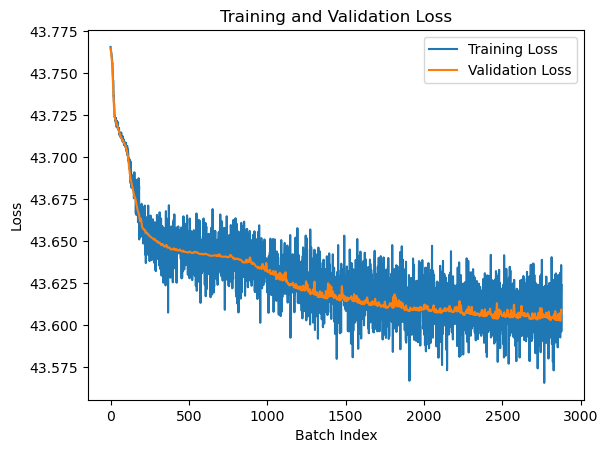

In [32]:
batch_idx_count = np.arange(0, len(train_loss_values))

train_loss_values = torch.tensor(train_loss_values).cuda()
train_loss_values_cpu = train_loss_values.cpu().tolist()

val_loss_values = torch.tensor(val_loss_values).cuda()
val_loss_values_cpu = val_loss_values.cpu().tolist()


fig, ax = plt.subplots()

ax.plot(batch_idx_count, train_loss_values_cpu, label='Training Loss')
ax.plot(batch_idx_count, val_loss_values_cpu, label='Validation Loss')


ax.legend()


ax.set_xlabel('Batch Index')
ax.set_ylabel('Loss')
ax.set_title('Training and Validation Loss')


plt.show()
